In [2]:
# Originally made by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings)
# The original BigGAN+CLIP method was by https://twitter.com/advadnoun

import argparse
import math
import random
# from email.policy import default
from urllib.request import urlopen
from tqdm import tqdm
import sys
import os

# pip install taming-transformers doesn't work with Gumbel, but does not yet work with coco etc
# appending the path does work with Gumbel, but gives ModuleNotFoundError: No module named 'transformers' for coco etc
sys.path.append('taming-transformers')

from omegaconf import OmegaConf
from taming.models import cond_transformer, vqgan
#import taming.modules 

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.cuda import get_device_properties
torch.backends.cudnn.benchmark = False		# NR: True is a bit faster, but can lead to OOM. False is more deterministic.
#torch.use_deterministic_algorithms(True)	# NR: grid_sampler_2d_backward_cuda does not have a deterministic implementation

from torch_optimizer import DiffGrad, AdamP, RAdam

from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio

from PIL import ImageFile, Image, PngImagePlugin, ImageChops
ImageFile.LOAD_TRUNCATED_IMAGES = True

from subprocess import Popen, PIPE
import re

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#AudioCLIP

import glob

import librosa
import librosa.display

import simplejpeg

import torchvision as tv

import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Audio, display

sys.path.append('AudioCLIP')

from model import AudioCLIP
from utils.transforms import ToTensor1D

MODEL_FILENAME = 'AudioCLIP-Full-Training.pt'
# derived from ESResNeXt
SAMPLE_RATE = 44100
# derived from CLIP
IMAGE_SIZE = 224
IMAGE_MEAN = 0.48145466, 0.4578275, 0.40821073
IMAGE_STD = 0.26862954, 0.26130258, 0.27577711

In [4]:
torch.set_grad_enabled(True)

# AudioCLIP

In [5]:
aclp = AudioCLIP(pretrained=f'AudioCLIP/assets/{MODEL_FILENAME}')

In [6]:
audio_transforms = ToTensor1D()

image_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(IMAGE_SIZE, interpolation=Image.BICUBIC),
    tv.transforms.CenterCrop(IMAGE_SIZE),
    tv.transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])

In [7]:
def read_data(img_dir, audio_dir):
    img_dir += "*.jpg"
    audio_dir += "*.wav"
    
    paths_to_audio = glob.glob(audio_dir)

    audio = list()
    for path_to_audio in paths_to_audio:
        track, _ = librosa.load(path_to_audio, sr=SAMPLE_RATE, dtype=np.float32)
        # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
        # thus, the actual time-frequency representation will be visualized
        spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)))
        spec = np.ascontiguousarray(spec.numpy()).view(np.complex64)
        pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()

        audio.append((track, pow_spec))
    
    paths_to_images = glob.glob(img_dir)

    images = list()
    for path_to_image in paths_to_images:
        with open(path_to_image, 'rb') as jpg:
            image = simplejpeg.decode_jpeg(jpg.read())
            images.append(image)
    return images, audio

In [19]:
def read_track(audio_dir):
    audio = []
    
    track, _ = librosa.load(audio_dir, sr=SAMPLE_RATE, dtype=np.float32)
    # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
    # thus, the actual time-frequency representation will be visualized
    spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)))
    spec = np.ascontiguousarray(spec.numpy()).view(np.complex64)
    pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()

    audio.append((track, pow_spec))
    
    return audio

In [9]:
def embedding(text = None, images = None, audio = None):
    text_features = []
    image_features = []
    audio_features = []
    
    if audio != None: 
        audio = torch.stack([audio_transforms(track.reshape(1, -1)) for track, _ in audio])
        ((audio_features, _, _), _), _ = aclp(audio=audio)
        audio_features = audio_features / torch.linalg.norm(audio_features, dim=-1, keepdim=True)
    if images != None:
        images = torch.stack([image_transforms(image) for image in images])
        ((_, image_features, _), _), _ = aclp(image=images)
        image_features = image_features / torch.linalg.norm(image_features, dim=-1, keepdim=True)
    if text != None:
        text = [[label] for label in text]
        ((_, _, text_features), _), _ = aclp(text=text)
        text_features = text_features / torch.linalg.norm(text_features, dim=-1, keepdim=True)
    return text_features, image_features, audio_features

# VQGAN

In [10]:
# Check for GPU and reduce the default image size if low VRAM
default_image_size = 512  # >8GB VRAM
if not torch.cuda.is_available():
    default_image_size = 256  # no GPU found
elif get_device_properties(0).total_memory <= 2 ** 33:  # 2 ** 33 = 8,589,934,592 bytes = 8 GB
    default_image_size = 318  # <8GB VRAM

In [11]:
prompts = None
max_iterations = 500
save_every = 50
size = [256, 256]
clip_model = 'ViT-B/32'
vqgan_config = f'checkpoints/vqgan_imagenet_f16_16384.yaml'
vqgan_checkpoint = f'checkpoints/vqgan_imagenet_f16_16384.ckpt'
learning_rate = 0.1
step_size = 0.1
cut_method = 'latest'
cutn = 32
cut_pow = 1.0
output = "output.png"
augments = [['Af', 'Pe', 'Ji', 'Er']]
cuda_device = "cuda:0"
seed = None
display_freq = 50

In [12]:
if prompts == None:
    prompts = "A cute, smiling, Nerdy Rodent"

# Split text prompts using the pipe character (weights are split later)
if prompts != None:
    # For stories, there will be many phrases
    story_phrases = [phrase.strip() for phrase in prompts.split("^")]
    
    # Make a list of all phrases
    all_phrases = []
    for phrase in story_phrases:
        all_phrases.append(phrase.split("|"))
    
    # First phrase
    prompts = all_phrases[0]

In [13]:
if not cuda_device == 'cpu' and not torch.cuda.is_available():
    cuda_device = 'cpu'
    print("Warning: No GPU found! Using the CPU instead. The iterations will be slow.")
    print("Perhaps CUDA/ROCm or the right pytorch version is not properly installed?")

In [14]:
# Various functions and classes
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

# Used in older MakeCutouts
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)

replace_grad = ReplaceGrad.apply


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

clamp_with_grad = ClampWithGrad.apply


def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


#NR: Split prompts and weights
def split_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow # not used with pooling
        
        # Pick your own augments & their order
        augment_list = []
        for item in augments[0]:
            if item == 'Ji':
                augment_list.append(K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.7))
            elif item == 'Sh':
                augment_list.append(K.RandomSharpness(sharpness=0.3, p=0.5))
            elif item == 'Gn':
                augment_list.append(K.RandomGaussianNoise(mean=0.0, std=1., p=0.5))
            elif item == 'Pe':
                augment_list.append(K.RandomPerspective(distortion_scale=0.7, p=0.7))
            elif item == 'Ro':
                augment_list.append(K.RandomRotation(degrees=15, p=0.7))
            elif item == 'Af':
                augment_list.append(K.RandomAffine(degrees=15, translate=0.1, shear=5, p=0.7, padding_mode='zeros', keepdim=True)) # border, reflection, zeros
            elif item == 'Et':
                augment_list.append(K.RandomElasticTransform(p=0.7))
            elif item == 'Ts':
                augment_list.append(K.RandomThinPlateSpline(scale=0.8, same_on_batch=True, p=0.7))
            elif item == 'Cr':
                augment_list.append(K.RandomCrop(size=(self.cut_size,self.cut_size), pad_if_needed=True, padding_mode='reflect', p=0.5))
            elif item == 'Er':
                augment_list.append(K.RandomErasing(scale=(.1, .4), ratio=(.3, 1/.3), same_on_batch=True, p=0.7))
            elif item == 'Re':
                augment_list.append(K.RandomResizedCrop(size=(self.cut_size,self.cut_size), scale=(0.1,1),  ratio=(0.75,1.333), cropping_mode='resample', p=0.5))
                
        self.augs = nn.Sequential(*augment_list)
        self.noise_fac = 0.1
        # self.noise_fac = False

        # Uncomment if you like seeing the list ;)
        # print(augment_list)
        
        # Pooling
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        cutouts = []
        
        for _ in range(self.cutn):            
            # Use Pooling
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
            
        batch = self.augs(torch.cat(cutouts, dim=0))
        
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch



def load_vqgan_model(config_path, checkpoint_path):
    global gumbel
    gumbel = False
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
        gumbel = True
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model


def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)


# Do It

In [59]:
# Do it
device = torch.device(cuda_device)
model = load_vqgan_model(vqgan_config, vqgan_checkpoint).to(device)
jit = True if float(torch.__version__[:3]) < 1.8 else False
perceptor = AudioCLIP(pretrained=f'AudioCLIP/assets/{MODEL_FILENAME}').eval().requires_grad_(False)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from checkpoints/vqgan_imagenet_f16_16384.ckpt


In [60]:
cut_size = perceptor.visual.input_resolution
f = 2**(model.decoder.num_resolutions - 1)

make_cutouts = MakeCutouts(cut_size, cutn, cut_pow=cut_pow) 

toksX, toksY = size[0] // f, size[1] // f
sideX, sideY = toksX * f, toksY * f

# Gumbel or not?
e_dim = model.quantize.e_dim
n_toks = model.quantize.n_e
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

In [61]:
one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
z = one_hot @ model.quantize.embedding.weight

z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
    #z = torch.rand_like(z)*2						# NR: check

z_orig = z.clone()
z.requires_grad_(True)#Init Z

tensor([[[[ 5.4284e-05, -2.2617e-05, -4.0192e-05,  ..., -2.7823e-05,
            2.5441e-05, -2.8824e-05],
          [-5.3842e-05, -4.8142e-05, -8.0039e-06,  ...,  1.5466e-05,
           -5.6673e-05, -1.3865e-05],
          [-3.7111e-05,  1.9764e-05, -5.4443e-05,  ..., -3.0294e-05,
            4.4726e-05, -5.1171e-05],
          ...,
          [ 1.1145e-01,  3.8234e-05, -1.1047e-05,  ...,  4.6624e-05,
            1.4061e+00, -3.7422e-05],
          [ 2.6802e-05,  5.9465e-05,  1.0938e-05,  ...,  3.5275e-05,
            2.9019e-05,  4.0453e-05],
          [ 1.4581e-05,  3.3172e-05, -3.4035e-05,  ..., -2.9914e-05,
           -4.1584e-05,  3.7242e-05]],

         [[-1.6671e-05, -3.0863e-05, -3.1404e-05,  ...,  1.6166e-05,
            5.2999e-05,  5.4037e-05],
          [ 2.6484e-05,  2.0904e-08,  3.2249e-05,  ..., -2.4681e-05,
           -3.6037e-05,  1.5438e-05],
          [ 5.4852e-05, -2.8750e-05, -2.4279e-05,  ..., -7.3950e-06,
            6.7106e-06,  3.3614e-05],
          ...,
     

In [62]:
output = "cat_3.png"
audio_dir = "sound/cat.wav"

aclp = AudioCLIP(pretrained=f'AudioCLIP/assets/{MODEL_FILENAME}').eval().requires_grad_(False)
audio = read_track(audio_dir)
_, _, audio_rep = embedding(audio = audio)

In [63]:
pMs = []
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                  std=[0.26862954, 0.26130258, 0.27577711])

pMs.append(Prompt(audio_rep).to(device))

In [64]:
opt = optim.Adam([z], lr= step_size)

In [65]:
# Output for the user
print('Using device:', device)
print('Optimising using:', opt)

Using device: cuda:0
Optimising using: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)


In [66]:
if seed is None:
    seed = torch.seed()
else:
    seed = seed  
torch.manual_seed(seed)
print('Using seed:', seed)

Using seed: 16748008088144064978


In [67]:
# Vector quantize
def synth(z):
    if gumbel:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
    else:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)


#@torch.no_grad()
@torch.inference_mode()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    info = PngImagePlugin.PngInfo()
    TF.to_pil_image(out[0].cpu()).save(output, pnginfo=info) 
    plt.imshow(TF.to_pil_image(out[0].cpu()))
    
def ascend_txt():
    global i
    out = synth(z)
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()
    
    result = []
    
    for prompt in pMs:
        result.append(prompt(iii))
    return result # return loss



In [68]:
def train(i):
    opt.zero_grad(set_to_none=True)
    lossAll = ascend_txt()
    
    if i % display_freq == 0:
        checkin(i, lossAll)
       
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    
    #with torch.no_grad():
    with torch.inference_mode():
        z.copy_(z.maximum(z_min).minimum(z_max))

0it [00:00, ?it/s]

i: 0, loss: 0.991065, losses: 0.991065


51it [00:10,  4.38it/s]

i: 50, loss: 0.81876, losses: 0.81876


101it [00:20,  4.44it/s]

i: 100, loss: 0.795689, losses: 0.795689


151it [00:30,  4.40it/s]

i: 150, loss: 0.788803, losses: 0.788803


200it [00:41,  3.85it/s]

i: 200, loss: 0.768685, losses: 0.768685


251it [00:53,  4.20it/s]

i: 250, loss: 0.764865, losses: 0.764865


300it [01:05,  4.17it/s]

i: 300, loss: 0.74058, losses: 0.74058


351it [01:16,  4.44it/s]

i: 350, loss: 0.738441, losses: 0.738441


401it [01:26,  4.41it/s]

i: 400, loss: 0.76285, losses: 0.76285


451it [01:36,  4.41it/s]

i: 450, loss: 0.769832, losses: 0.769832


500it [01:48,  4.11it/s]

i: 500, loss: 0.74276, losses: 0.74276


500it [01:48,  4.60it/s]


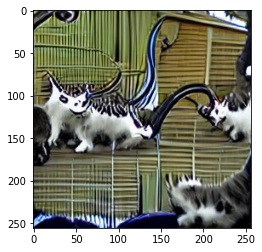

In [69]:
perceptor.cuda()
i = 0 # Iteration counter

# Do it
try:
    with tqdm() as pbar:
        while True:            
           
            train(i)
            
            # Ready to stop yet?
            if i == max_iterations:
                break
                
            i += 1
            pbar.update()
except KeyboardInterrupt:
    pass

# Easier Callable Function

In [75]:
prompts = None
max_iterations = 500
save_every = 50
size = [512, 512]
clip_model = 'ViT-B/32'
vqgan_config = f'checkpoints/vqgan_imagenet_f16_16384.yaml'
vqgan_checkpoint = f'checkpoints/vqgan_imagenet_f16_16384.ckpt'
learning_rate = 0.1
step_size = 0.1
cut_method = 'latest'
cutn = 32
cut_pow = 1.0
augments = [['Af', 'Pe', 'Ji', 'Er']]
cuda_device = "cuda:0"
seed = None
display_freq = 50

In [76]:
output = "cat_5.png"
audio_dir = "sound/cat.wav"

In [77]:
torch.cuda.empty_cache()

# Do it
device = torch.device(cuda_device)
model = load_vqgan_model(vqgan_config, vqgan_checkpoint).to(device)
jit = True if float(torch.__version__[:3]) < 1.8 else False
perceptor = AudioCLIP(pretrained=f'AudioCLIP/assets/{MODEL_FILENAME}').eval().requires_grad_(False)

cut_size = perceptor.visual.input_resolution
f = 2**(model.decoder.num_resolutions - 1)

make_cutouts = MakeCutouts(cut_size, cutn, cut_pow=cut_pow) 

toksX, toksY = size[0] // f, size[1] // f
sideX, sideY = toksX * f, toksY * f

# Gumbel or not?
e_dim = model.quantize.e_dim
n_toks = model.quantize.n_e
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
z = one_hot @ model.quantize.embedding.weight

z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
    #z = torch.rand_like(z)*2						# NR: check

z_orig = z.clone()
z.requires_grad_(True)#Init Z

aclp = AudioCLIP(pretrained=f'AudioCLIP/assets/{MODEL_FILENAME}').eval().requires_grad_(False)
audio = read_track(audio_dir)
_, _, audio_rep = embedding(audio = audio)

pMs = []
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                  std=[0.26862954, 0.26130258, 0.27577711])

pMs.append(Prompt(audio_rep).to(device))

opt = optim.Adam([z], lr= step_size)

if seed is None:
    seed = torch.seed()
else:
    seed = seed  
torch.manual_seed(seed)
print('Using seed:', seed)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from checkpoints/vqgan_imagenet_f16_16384.ckpt
Using seed: 10184948708101081601


In [78]:
perceptor.cuda()
i = 0 # Iteration counter

# Do it
try:
    with tqdm() as pbar:
        while True:            
           
            train(i)
            
            # Ready to stop yet?
            if i == max_iterations:
                break
                
            i += 1
            pbar.update()
except KeyboardInterrupt:
    pass

0it [00:00, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 10.76 GiB total capacity; 9.20 GiB already allocated; 17.50 MiB free; 9.34 GiB reserved in total by PyTorch)